In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

original_df = pd.read_csv('../data/all_financial_with_keywords.csv')

### Prep Target Column
def prep_target_variable(original_df, column='diff'):
    # Convert to percent based deltas
    original_df['open'] = original_df[column] + original_df['close']
    original_df['diff_percent'] = original_df[column] / original_df['close']
    
   # Remove the over 100% change values
    final_df = original_df[(original_df['diff_percent'] > -1.0) & (original_df['diff_percent'] < 1.0)]
    return final_df

original_df = prep_target_variable(original_df)
target_column = 'diff_percent'

### Setup Bank Column Group and Dataframe
bank_columns = [
    'citigroup', 'citi', 'morgan stanley', 'ubs', 'barclays', 'wells fargo', 
    'goldman sachs', 'deutsche bank', 'credit suisse', 'merrill lynch', 
    'rbc capital', 'jefferies', 'stifel', 'morgan stanley.1', 'merrill lynch.1', 
    'goldman sachs.1', 'raymond james', 'piper jaffray', 'robert w. baird', 
    'william blair', 'william blair.1', 'hill road', target_column
]
bank_df = original_df[bank_columns]
bank_df.head()

,citigroup,citi,morgan stanley,ubs,barclays,wells fargo,goldman sachs,deutsche bank,credit suisse,merrill lynch,...,morgan stanley.1,merrill lynch.1,goldman sachs.1,raymond james,piper jaffray,robert w. baird,william blair,william blair.1,hill road,diff_percent
0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029333
1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002051
2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,6.0,NaN,NaN,NaN,NaN,0.004995
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007323


# Group 1: Bank Name Counts

This data is the count of a bank name appearance in an ipo prospectus document.

## Cleaning

1. Fill NA values with 0, as NA just means the bank was not present in document.
2. Remove duplicate bank names that are disguised with a '.1'

In [45]:
### Convert NA to 0
bank_df = bank_df.fillna(0)

### Remove Dupes
dupes = [
    'morgan stanley.1',
    'merrill lynch.1',
    'goldman sachs.1',
    'william blair.1'
]

for dupe in dupes:
    if not dupe in bank_df:
        continue
    root_name=dupe.split('.')[0]
    bank_df[root_name] = bank_df[root_name] + bank_df[dupe]
    bank_df = bank_df.drop(dupe, axis=1)

## Bank Name Count Distribution

The initiall hypothesis for this type of data was a Poisson, random events in time or space. These are word counts in a document, and one document does not affect the next. The null hypothesis is accepted in this case that no Poisson is present. And even further distribution testing has confirmed that this group does not have a standard statistical distribution.

H(0) = No Poisson Distribution H(1) = Poisson Distribution
Significance Level = 0.05 Experiment: Kolmogorov-Smirnov test comparing observed data to theoretical Poisson distribution Result: P_Value = 0.0 for all columns in group

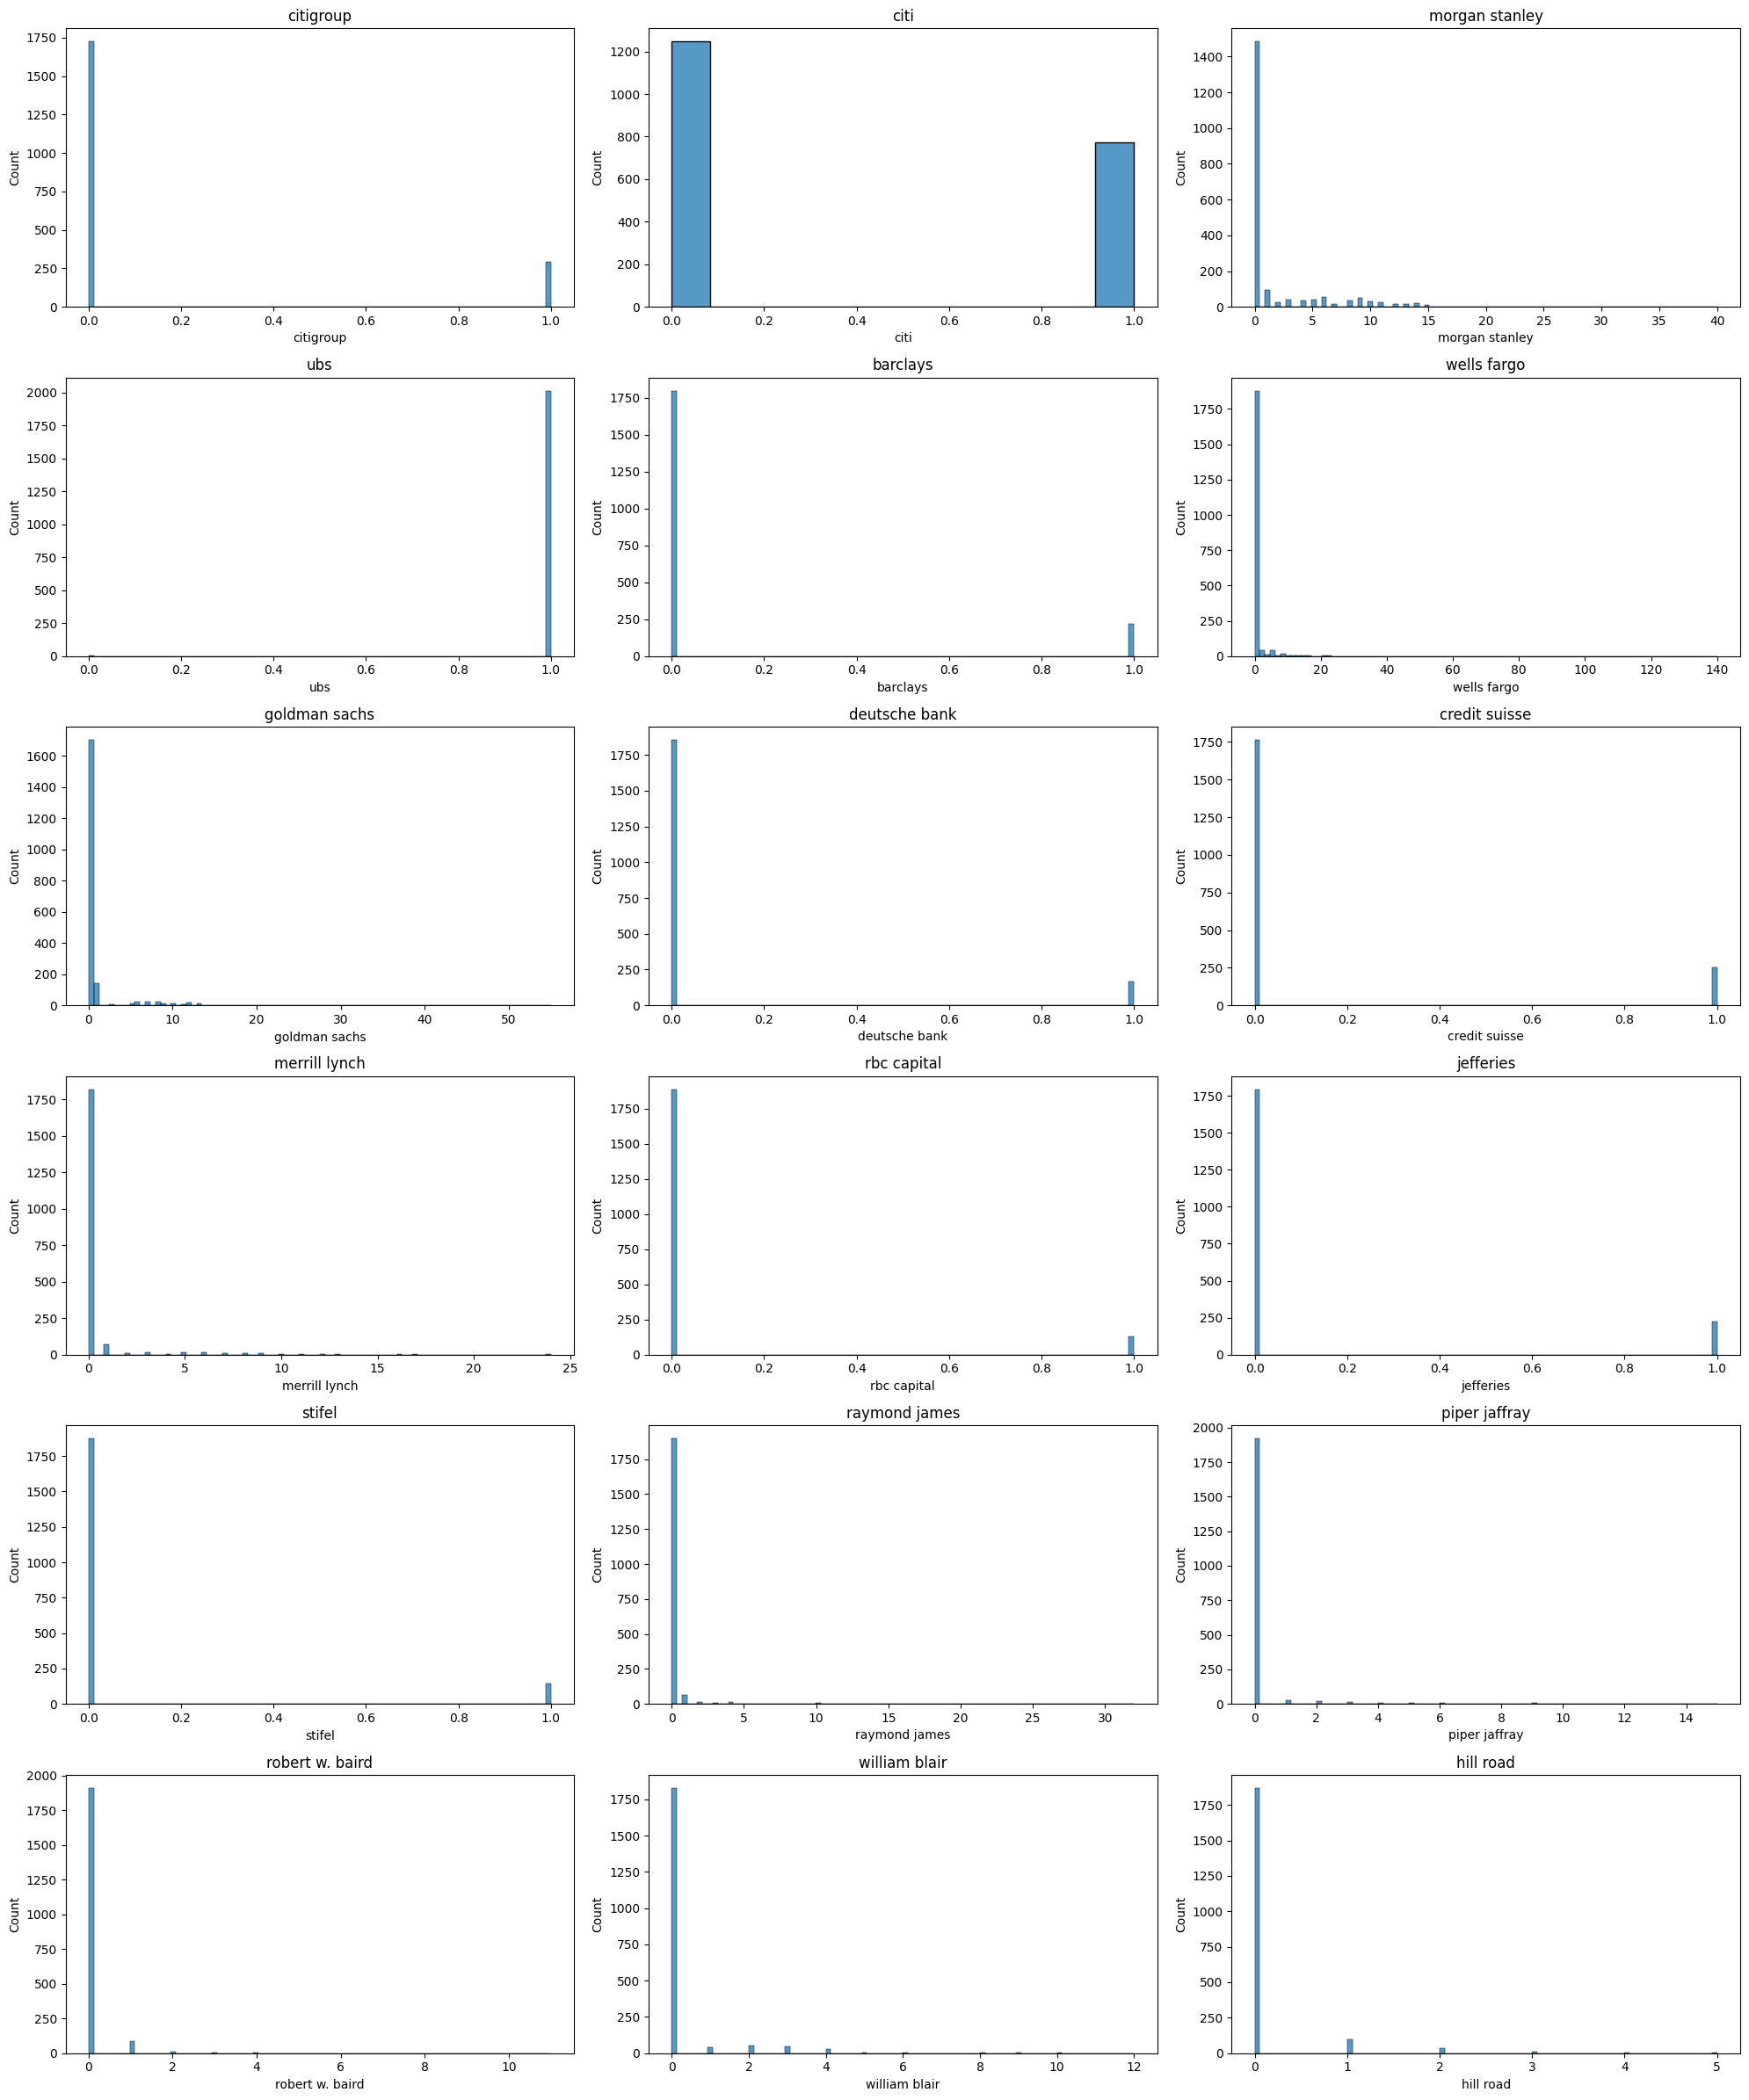

In [48]:
### View Distributions
cols=bank_df.columns
n = len(cols)

n_rows = 6
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 24))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.histplot(data=bank_df, x=col, ax=ax)
    ax.set_title(col)

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [49]:
### Attempt Poisson Proof

row_list = []

for bank_name in bank_df.columns:
    data = bank_df[bank_name]
    
    mean = data.mean()
    variance = data.var()
    ratio = variance / mean

     # Skip if all zeros or constant
    if data.std() == 0:
        print(f"Skipping {bank_name}: No variation in data")
        continue
    
    lambda_param = mean
    alpha = 0.05
    try:
        ks_stat, p_value = stats.kstest(data, 
                                       lambda x: stats.poisson.cdf(x, lambda_param))
    except:
        ks_stat, p_value = np.nan, np.nan
    
    row_list.append({
        'bank': bank_name,
        'positive_ints': all(data >= 0) and all(data == data.astype(int)),
        'mean': mean,
        'variance': variance,
        'ratio': ratio,
        'strong poisson': abs(ratio - 1) < 0.1,
        'overdispersed': ratio > 1.5,
        'underdispersed': ratio < 0.8,
        'ks_stat': ks_stat,
        'p_value': p_value,
        'reject poisson': p_value < alpha
    })
poisson_df = pd.DataFrame(row_list)
print(poisson_df)

print(f"Contains only integers: {all(data == data.astype(int))}")

               bank  positive_ints      mean   variance      ratio  \
0         citigroup           True  0.145265   0.124225   0.855159   
1              citi           True  0.382251   0.236252   0.618056   
2    morgan stanley           True  1.841349  16.703984   9.071604   
3               ubs           True  0.997521   0.002474   0.002480   
4          barclays           True  0.108577   0.096836   0.891865   
5       wells fargo           True  0.571145  14.640893  25.634272   
6     goldman sachs           True  0.994546  13.585784  13.660282   
7     deutsche bank           True  0.081805   0.075150   0.918651   
8     credit suisse           True  0.126425   0.110497   0.874008   
9     merrill lynch           True  0.525533   4.909194   9.341362   
10      rbc capital           True  0.064452   0.060328   0.936012   
11        jefferies           True  0.111056   0.098772   0.889385   
12           stifel           True  0.071889   0.066754   0.928571   
13    raymond james 

## Feature Scale

Determine if there is a difference between promincence (magnitude) and presence (at least 1 count). This would help determine if the data should be scaled to binary values or use some other method. Given there is not a standard distribution present, and the data is significatly 0 inflated, it is hard to simply apply something such as a log function.

The result concluded that it depened on the bank name. Therefore, leaving the scale as is seems to be the best approach.

In [51]:
count_correlations = bank_df.corr(method='spearman')[target_column]
count_correlations

citigroup          0.057156
citi               0.027447
morgan stanley     0.029783
ubs                0.031842
barclays           0.048067
wells fargo        0.028566
goldman sachs      0.048185
deutsche bank      0.036273
credit suisse      0.083703
merrill lynch      0.029806
rbc capital        0.033157
jefferies          0.036932
stifel             0.025488
raymond james      0.007850
piper jaffray     -0.005323
robert w. baird    0.050168
william blair      0.039874
hill road         -0.011915
diff_percent       1.000000
Name: diff_percent, dtype: float64

In [52]:
binary_mentions = (bank_df > 0).astype(int)
binary_correlations = binary_mentions.corr(method='spearman')[target_column]
binary_correlations

citigroup          0.042699
citi               0.014233
morgan stanley     0.037664
ubs                0.023472
barclays           0.029277
wells fargo        0.042588
goldman sachs      0.026496
deutsche bank      0.031040
credit suisse      0.061730
merrill lynch      0.031255
rbc capital        0.027172
jefferies          0.038011
stifel             0.004528
raymond james      0.027675
piper jaffray     -0.025431
robert w. baird    0.047474
william blair      0.036261
hill road         -0.008176
diff_percent       1.000000
Name: diff_percent, dtype: float64

In [53]:
# Difference between correlations
difference = binary_correlations - count_correlations
performance_retained = binary_correlations / count_correlations

comparison_df = pd.DataFrame({
    'count_corr': count_correlations,
    'binary_corr': binary_correlations,
    'difference': difference,
    'H(0) Accepted': difference != 0,
    'Prominent': difference < 0,
    'Presence': difference > 0
})
comparison_df

,count_corr,binary_corr,difference,H(0) Accepted,Prominent,Presence
citigroup,0.057156,0.042699,-0.014457,True,True,False
citi,0.027447,0.014233,-0.013214,True,True,False
morgan stanley,0.029783,0.037664,0.007881,True,False,True
ubs,0.031842,0.023472,-0.008370,True,True,False
barclays,0.048067,0.029277,-0.018791,True,True,False
wells fargo,0.028566,0.042588,0.014022,True,False,True
goldman sachs,0.048185,0.026496,-0.021689,True,True,False
deutsche bank,0.036273,0.031040,-0.005233,True,True,False
credit suisse,0.083703,0.061730,-0.021973,True,True,False
merrill lynch,0.029806,0.031255,0.001450,True,False,True


## Outliers

Data is has a zero inflated nature, so all values seem like an outlier. Nothing sticks out visualy either, so this will be left alone.

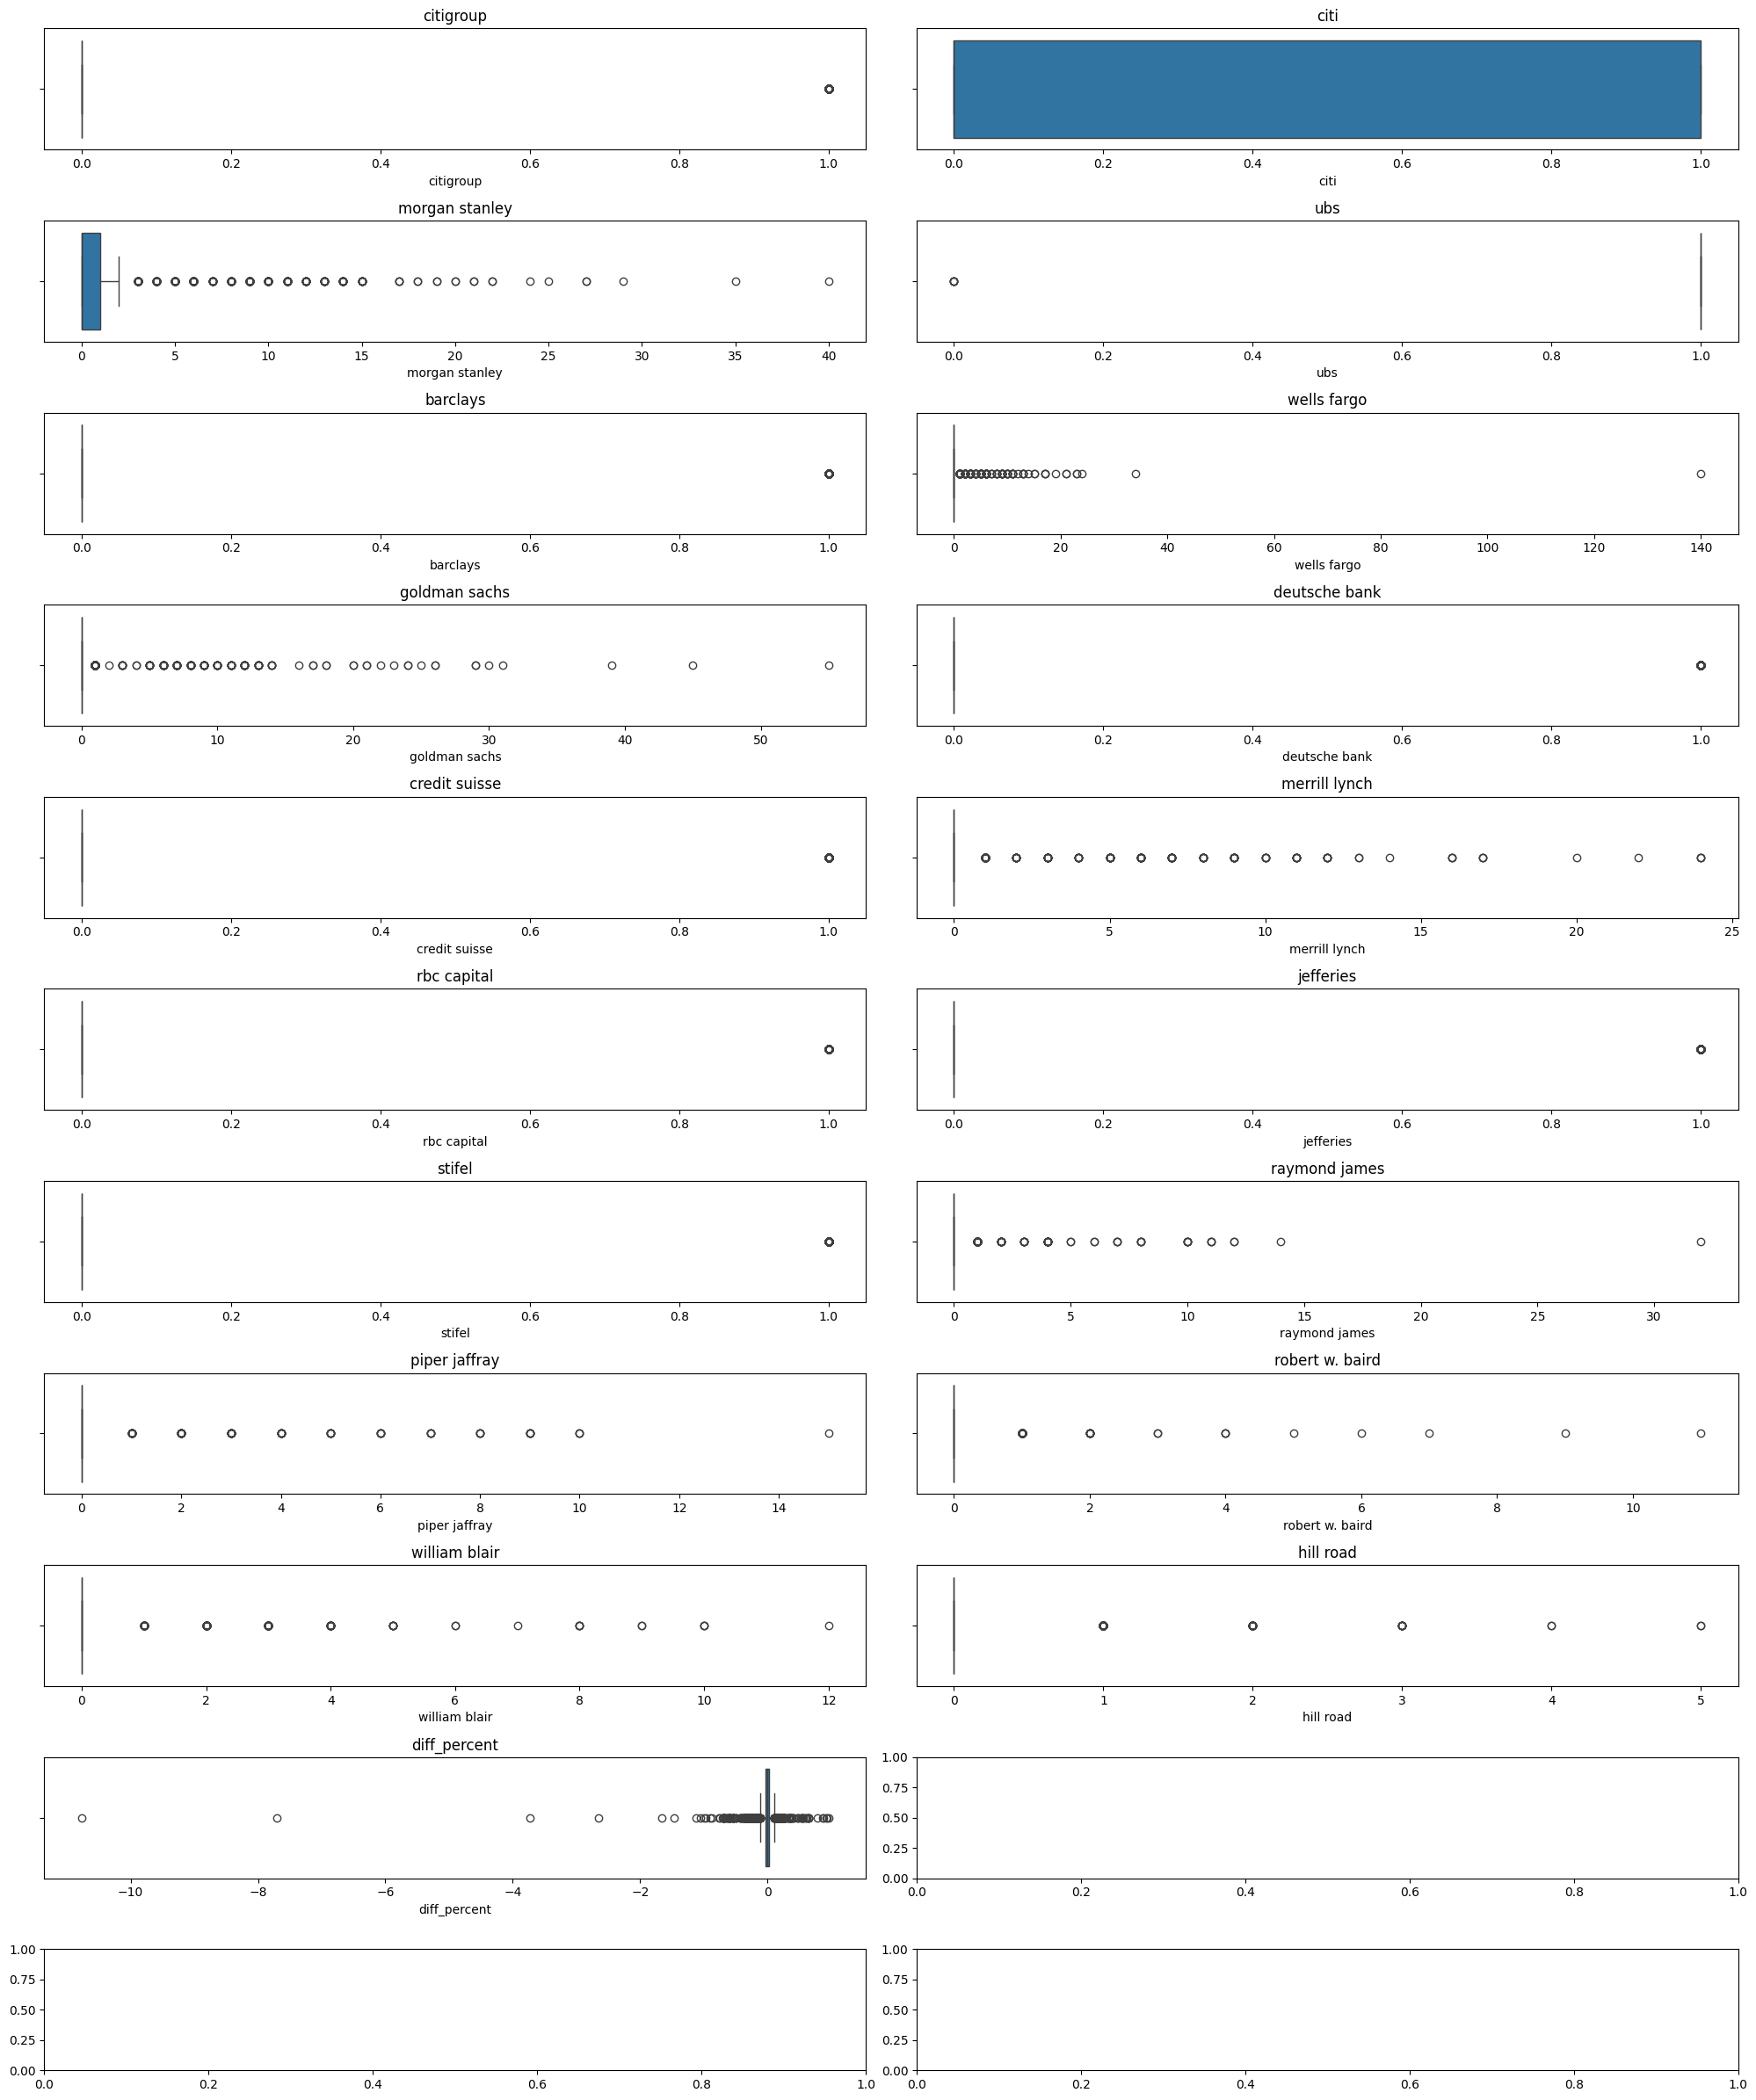

In [13]:
# Create Box Plots
cols=bank_df.columns
n = len(cols)

n_cols = 2
n_rows = 11

fig, axes = plt.subplots(n_rows, n_cols, figsize=[20,24])
axs = axes.flatten()

for ax, col in zip(axs, cols):
    sns.boxplot(x=bank_df[col], ax=ax)
    ax.set_title(col)

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## Feature Engineering

1. Give each bank a numberical index, and then one hot encode the ones in the row into a group called 'bank_group'
2. Total banks present in row as 'unique_bank_count'

In [65]:
### Bank Group Column

### Convert to binary data
df_binary = (bank_df > 0).astype(int)
df = df_binary.drop('diff_percent', axis=1)

### Find unique combinations of bank names in a row
columns_with_ones = df.apply(lambda row: [col for col, val in row.items() if val == 1], axis=1)
joined_cols = columns_with_ones.apply(lambda item: ", ".join(item))
unique_list = list(set(joined_cols))
print(len(unique_list)) # 588 unique groups, too many

### Create a one hot encoding as group
cols = list(bank_df.columns)

def encode_bank_name(bank_name):
    return cols.index(bank_name) 

df['bank_group'] = df.apply(lambda row: [col for col, val in row.items() if val == 1], axis=1)
df['bank_group'] = df['bank_group'].apply(lambda row: [encode_bank_name(bank) for bank in row])

KeyError: "['diff_percent'] not found in axis"

In [55]:
### Unique Bank Count Column

df['unique_bank_count'] = df['bank_group'].apply(lambda row: len(row))

,citigroup,citi,morgan stanley,ubs,barclays,wells fargo,goldman sachs,deutsche bank,credit suisse,merrill lynch,rbc capital,jefferies,stifel,raymond james,piper jaffray,robert w. baird,william blair,hill road,bank_group,unique_bank_count
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 1, 2, 3, 4]",5
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[3],1
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[3],1
3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,"[1, 3, 13, 14]",4
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[3],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[1, 3]",2
2021,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[3],1
2022,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[1, 3]",2
2023,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,"[1, 3, 7, 11]",4


In [64]:
### Final Algorithmn

def prepare_bank_count_feature(df):
    ### Convert NA to 0
    bank_df = df.fillna(0)

    ### Remove Dupes
    dupes = [
        'morgan stanley.1',
        'merrill lynch.1',
        'goldman sachs.1',
        'william blair.1'
    ]

    for dupe in dupes:
        if not dupe in bank_df:
            continue
        root_name=dupe.split('.')[0]
        bank_df[root_name] = bank_df[root_name] + bank_df[dupe]
        bank_df = bank_df.drop(dupe, axis=1)
        
    ### Feature Engineer Bank Group Column
    cols = list(bank_df.columns)
    bank_df['bank_group'] = bank_df.apply(lambda row: [col for col, val in row.items() if val >= 1], axis=1)
    bank_df['bank_group'] = bank_df['bank_group'].apply(lambda row: [cols.index(bank) for bank in row])

    ### Feature Engineer Unique Bank Count
    bank_df['unique_bank_count'] = bank_df['bank_group'].apply(lambda row: len(row))

    return bank_df

bank_columns = [
    'citigroup', 'citi', 'morgan stanley', 'ubs', 'barclays', 'wells fargo', 
    'goldman sachs', 'deutsche bank', 'credit suisse', 'merrill lynch', 
    'rbc capital', 'jefferies', 'stifel', 'morgan stanley.1', 'merrill lynch.1', 
    'goldman sachs.1', 'raymond james', 'piper jaffray', 'robert w. baird', 
    'william blair', 'william blair.1', 'hill road'
]
bank_df = original_df[bank_columns]

df = prepare_bank_count_feature(bank_df)
df.head()

,citigroup,citi,morgan stanley,ubs,barclays,wells fargo,goldman sachs,deutsche bank,credit suisse,merrill lynch,rbc capital,jefferies,stifel,raymond james,piper jaffray,robert w. baird,william blair,hill road,bank_group,unique_bank_count
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 1, 2, 3, 4]",5
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[3],1
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[3],1
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0,0.0,"[1, 3, 13, 14]",4
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[3],1
